## Week 5 - PCA and MNIST

### Heeatehr Tweedie, 16/02/23

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

# TensorFlow and tf.keras
import tensorflow as tf
import keras
import keras.layers
import keras.datasets.mnist

from scipy import linalg

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch


2023-02-16 14:11:38.821895: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-16 14:11:39.252938: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-16 14:11:39.387815: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-16 14:11:39.387867: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore 

In [2]:
# load data
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# re-scale inputs
train_images=train_images/255.0
test_images=test_images/255.0

# check shape of datasets
print("Shape of training images:",train_images.shape)
print("Length of training set labels:",len(train_labels))
print("First label:",train_labels[0])
print("Shape of testing images:",test_images.shape)
print("Length of testing set labels:",len(test_labels))

image_x = len(train_images[0,:,0])
image_y = len(train_images[0,0,:])


Shape of training images: (60000, 28, 28)
Length of training set labels: 60000
First label: 5
Shape of testing images: (10000, 28, 28)
Length of testing set labels: 10000


Define and compile model:

In [3]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(30,activation='relu'),
    keras.layers.Dense(15)
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.SGD(learning_rate=1.0),
              metrics=['accuracy'])

2023-02-16 14:11:48.273938: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-16 14:11:48.274863: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-16 14:11:48.274924: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (penguin): /proc/driver/nvidia/version does not exist
2023-02-16 14:11:48.284996: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Train model using MNIST dataset:

In [4]:
history = model.fit(train_images, train_labels, batch_size=100, epochs=15, validation_data=(test_images, test_labels))

Epoch 1/15
600/600 [==============================] - 3s 3ms/step - loss: 0.5561 - accuracy: 0.8273 - val_loss: 0.2804 - val_accuracy: 0.9167
Epoch 2/15
600/600 [==============================] - 1s 2ms/step - loss: 0.2788 - accuracy: 0.9186 - val_loss: 0.2717 - val_accuracy: 0.9149
Epoch 3/15
600/600 [==============================] - 1s 2ms/step - loss: 0.2449 - accuracy: 0.9266 - val_loss: 0.2562 - val_accuracy: 0.9210
Epoch 4/15
600/600 [==============================] - 1s 2ms/step - loss: 0.2207 - accuracy: 0.9335 - val_loss: 0.2001 - val_accuracy: 0.9401
Epoch 5/15
600/600 [==============================] - 1s 2ms/step - loss: 0.2034 - accuracy: 0.9387 - val_loss: 0.2348 - val_accuracy: 0.9288
Epoch 6/15
600/600 [==============================] - 1s 2ms/step - loss: 0.1891 - accuracy: 0.9441 - val_loss: 0.2085 - val_accuracy: 0.9389
Epoch 7/15
600/600 [==============================] - 1s 2ms/step - loss: 0.1802 - accuracy: 0.9464 - val_loss: 0.1819 - val_accuracy: 0.9489
Epoch 

In [5]:
print("train_images.shape: ",np.shape(train_images))
X=np.reshape(train_images,(60000,784))
print("X.shape:",np.shape(X))
mu=np.mean(X,axis=0)
x=X-mu
rho=np.cov(x,rowvar=False) # Make the covaraince matrix by np.cov
print("rho.shape:",np.shape(rho))

#Get the eigenvalues and vectors
vals,vecs=linalg.eigh(rho)
#vals is a 1-D array of the eigenvalues in ascending order, vecs is a columnwise array of the normalised
# eigenvectors such that vecs[:,i] is the eigenvector correspondong to vals[i]
print("vecs.shape:",np.shape(vecs))
print("vals.shape:",np.shape(vals))
vecs=np.flip(vecs)
vals=np.flip(vals)

train_images.shape:  (60000, 28, 28)
X.shape: (60000, 784)
rho.shape: (784, 784)
vecs.shape: (784, 784)
vals.shape: (784,)


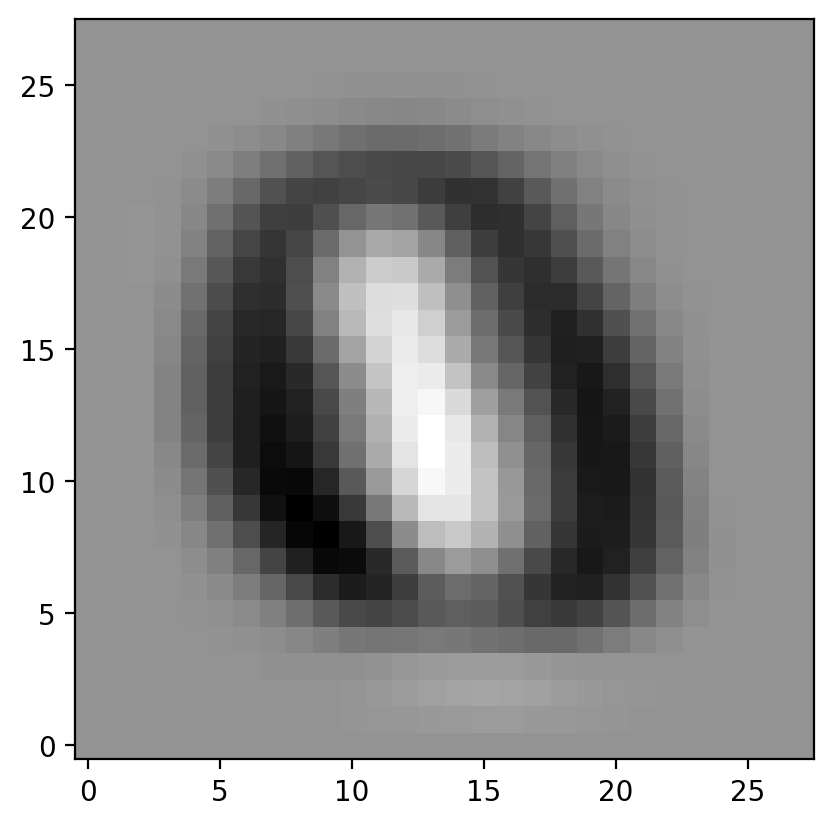

In [6]:
fig,ax=plt.subplots()
ax.imshow(np.reshape(vecs[:,0],[28,28]), origin='lower',cmap='binary',interpolation='nearest')

(784,)


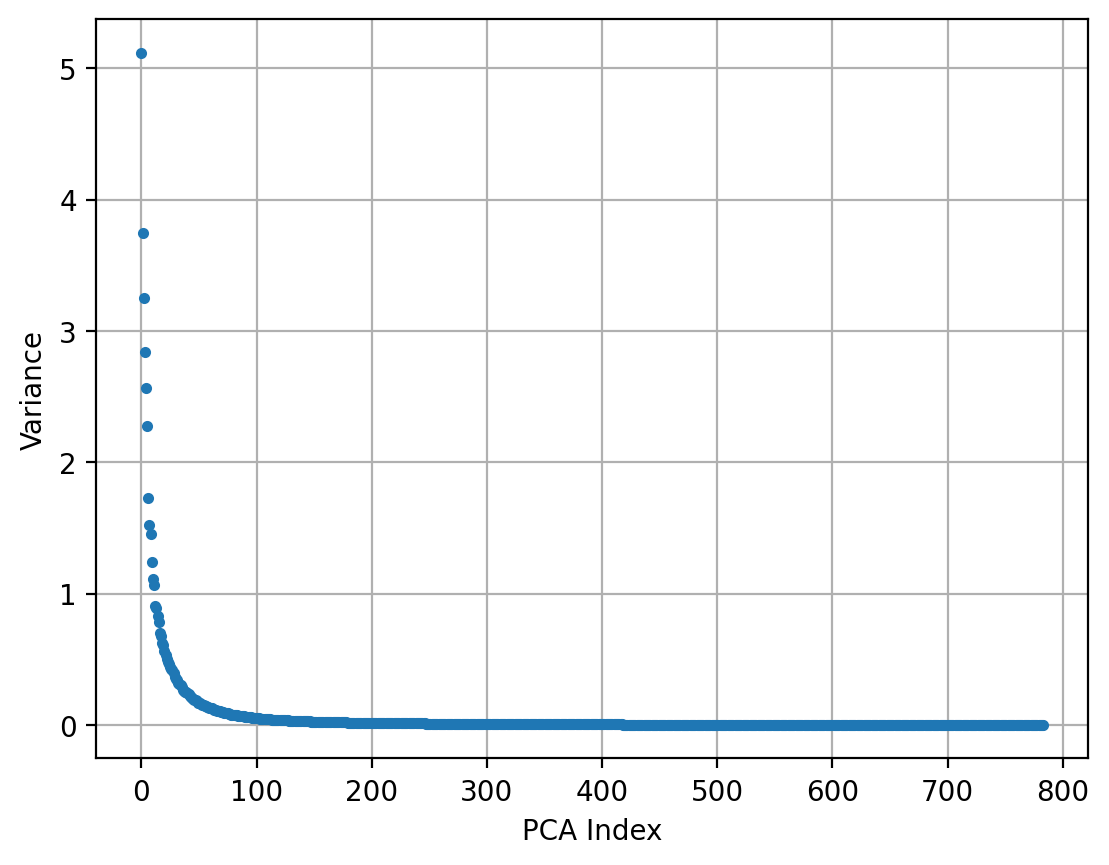

In [7]:
print(np.shape(vals))
fig,ax=plt.subplots()
index=np.arange((np.shape(vals)[0]))
ax.plot(index, vals.real, ".")
ax.set_xlabel("PCA Index")
ax.set_ylabel("Variance")
ax.grid()

x.shape: (60000, 784)
P.shape: (60000, 784)


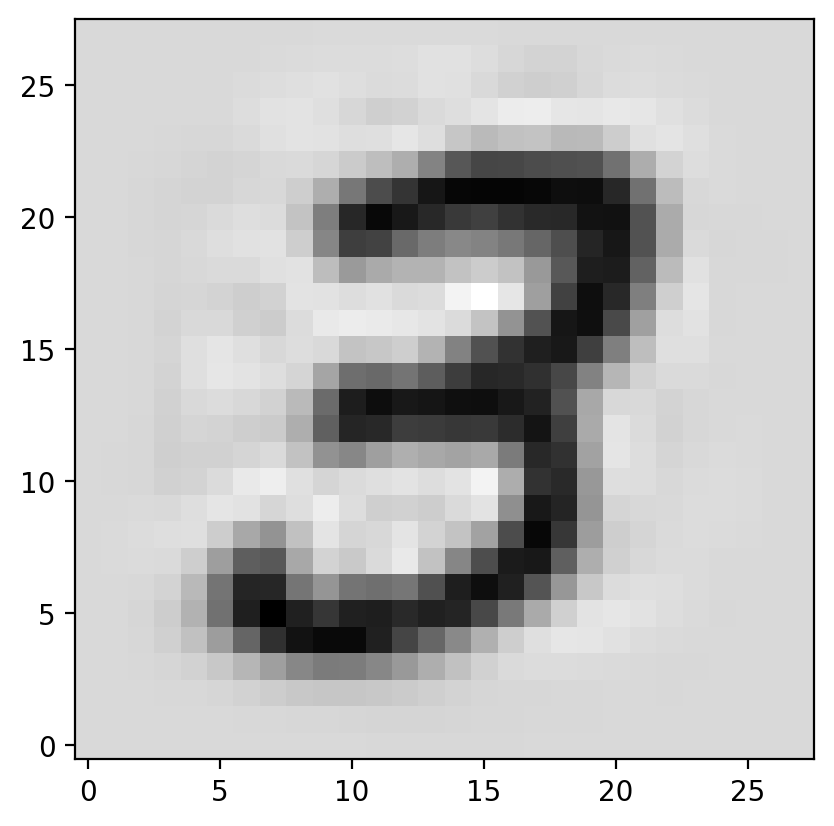

In [8]:
# create new testing dataset, where each image is the sum of the best N PCA components of the original image.
# Test the originally trained dataset using this new training dataset
# Repeat for different N, and plot to compare accuracies

P=np.dot(x,vecs)
print("x.shape:",x.shape)
print("P.shape:",P.shape)

newImage100=(np.dot(P[:,0:100],vecs.T[0:100,:]))+mu

whichImage = 7
fig,ax=plt.subplots()
ax.imshow(np.flipud(np.reshape(newImage100[whichImage,:],[28,28])), origin='lower',cmap='binary',interpolation='nearest')


In [9]:
# break down each test image into PCAs

print("test_images.shape: ", np.shape(test_images))

X = np.reshape(test_images, (10000, 784))
print("X.shape:", np.shape(X))

mu = np.mean(X, axis = 0)
x = X - mu
rho = np.cov(x, rowvar = False) # Make the covaraince matrix by np.cov
print("rho.shape: ", np.shape(rho))

#Get the eigenvalues and vectors
vals,vecs = linalg.eigh(rho)
#vals is a 1-D array of the eigenvalues in ascending order, vecs is a columnwise array of the normalised
# eigenvectors such that vecs[:,i] is the eigenvector correspondong to vals[i]
print("vecs.shape:",np.shape(vecs))
print("vals.shape:",np.shape(vals))
vecs=np.flip(vecs)
vals=np.flip(vals)


test_images.shape:  (10000, 28, 28)
X.shape: (10000, 784)
rho.shape:  (784, 784)
vecs.shape: (784, 784)
vals.shape: (784,)


In [10]:
# Re-combine first 100 PCAs

P=np.dot(x,vecs)
test_100 = (np.dot(P[:,0:200],vecs.T[0:200,:])) + mu



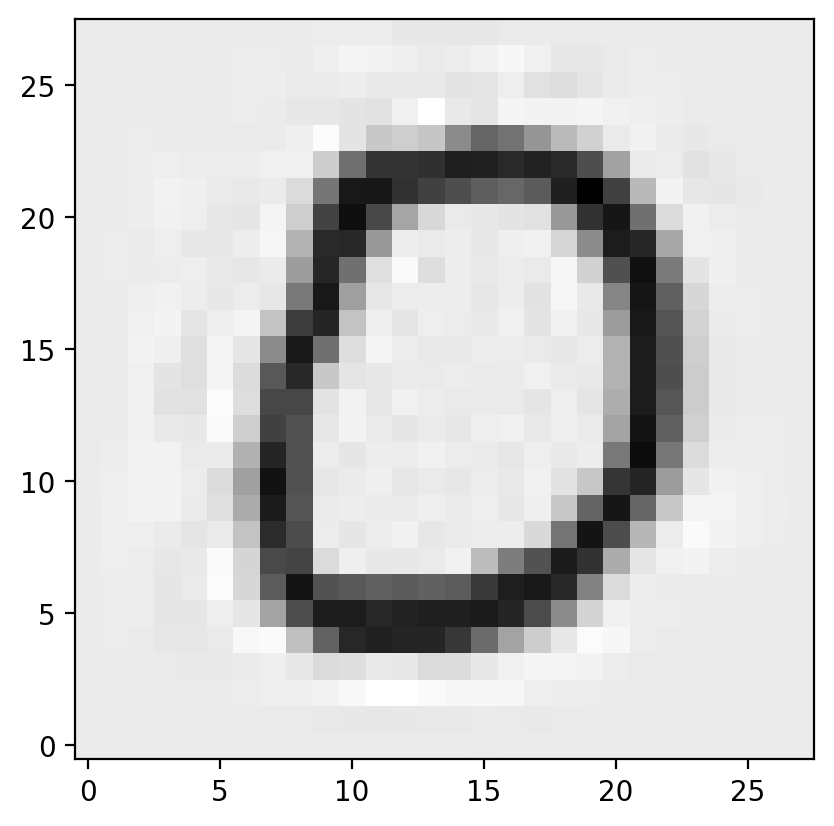

In [11]:
whichImage = 10
fig,ax=plt.subplots()
ax.imshow(np.flipud(np.reshape(test_100[whichImage,:],[28,28])), origin='lower',cmap='binary',interpolation='nearest')

In [12]:
test_loss, test_acc = model.evaluate(test_100, test_labels, verbose = 2)

313/313 - 1s - loss: 0.2221 - accuracy: 0.9380 - 1s/epoch - 5ms/step


313/313 - 0s - loss: 4.6603 - accuracy: 0.2215 - 339ms/epoch - 1ms/step
313/313 - 0s - loss: 1.6017 - accuracy: 0.6077 - 336ms/epoch - 1ms/step
313/313 - 0s - loss: 0.7345 - accuracy: 0.8003 - 389ms/epoch - 1ms/step
313/313 - 1s - loss: 0.4988 - accuracy: 0.8603 - 575ms/epoch - 2ms/step
313/313 - 0s - loss: 0.3683 - accuracy: 0.8973 - 341ms/epoch - 1ms/step
313/313 - 0s - loss: 0.3141 - accuracy: 0.9097 - 327ms/epoch - 1ms/step
313/313 - 1s - loss: 0.2909 - accuracy: 0.9170 - 547ms/epoch - 2ms/step
313/313 - 1s - loss: 0.2628 - accuracy: 0.9250 - 536ms/epoch - 2ms/step
313/313 - 1s - loss: 0.2508 - accuracy: 0.9285 - 593ms/epoch - 2ms/step
313/313 - 1s - loss: 0.2397 - accuracy: 0.9328 - 535ms/epoch - 2ms/step
313/313 - 1s - loss: 0.2355 - accuracy: 0.9354 - 652ms/epoch - 2ms/step
313/313 - 1s - loss: 0.2352 - accuracy: 0.9348 - 506ms/epoch - 2ms/step


Text(0.5, 1.0, 'Number of PCA components vs tes accuracy')

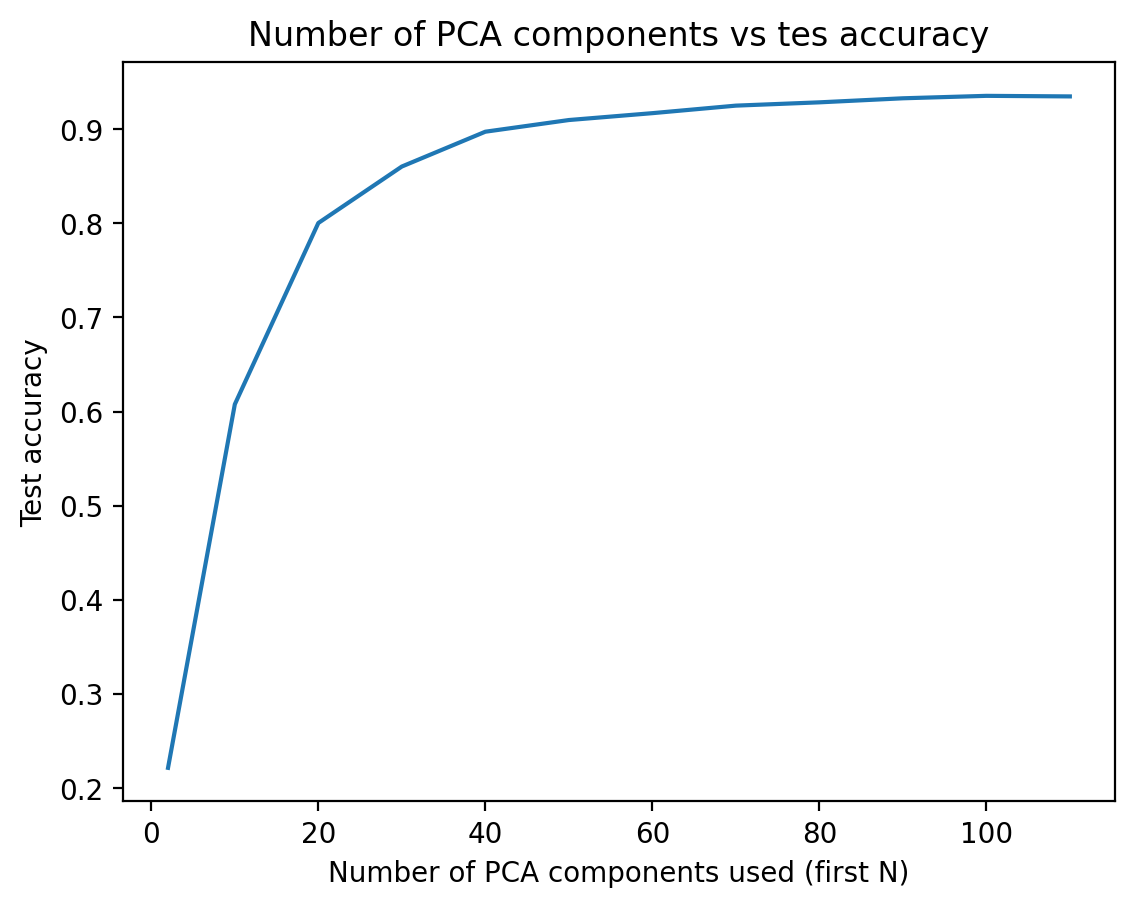

In [13]:
# do this for N = 2, 10, 50, 100, 200, 300, 400, 500, 600, all

N = [2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]

test_accuracies = np.empty(len(N))
for i in range(len(N)):
    P=np.dot(x,vecs)
    new_test = (np.dot(P[:,0:N[i]], vecs.T[0:N[i],:])) + mu
    test_loss, test_acc = model.evaluate(new_test, test_labels, verbose = 2)
    test_accuracies[i] = test_acc

fig, ax = plt.subplots()
ax.plot(N, test_accuracies)
ax.set_xlabel('Number of PCA components used (first N)')
ax.set_ylabel('Test accuracy')
ax.set_title('Number of PCA components vs tes accuracy')



In [14]:
# new training dataset with first 100 PCA components of full MNIST dataset

X = np.reshape(train_images, (60000, 784))
print("X.shape:", np.shape(X))

mu = np.mean(X, axis = 0)
x = X - mu
rho = np.cov(x, rowvar = False) # Make the covaraince matrix by np.cov
print("rho.shape: ", np.shape(rho))

#Get the eigenvalues and vectors
vals, vecs = linalg.eigh(rho)
#vals is a 1-D array of the eigenvalues in ascending order, vecs is a columnwise array of the normalised
# eigenvectors such that vecs[:,i] is the eigenvector correspondong to vals[i]
print("vecs.shape:",np.shape(vecs))
print("vals.shape:",np.shape(vals))
vecs=np.flip(vecs)
vals=np.flip(vals)


X.shape: (60000, 784)
rho.shape:  (784, 784)
vecs.shape: (784, 784)
vals.shape: (784,)


In [15]:
P=np.dot(x,vecs)
new_training_100 = (np.dot(P[:,0:100], vecs.T[0:100,:])) + mu

In [ ]:


history = model.fit(new_training_100, train_labels, batch_size=100, epochs=15, validation_data=(test_images, test_labels))